## Data Camp Project

# Credit Card Fraud Detection 

Authors:
  * Yuhe Bai
  * Jérôme Bonnin
  * Louis Mercier
  * Dan Allouche
  * Lotfi Kobrosly

## Table of contents

## Introduction

The number of credit card transaction is increasing with technological developments and the rise of e-commerce. It is a fact, credit card payments facilitate buisness activities. However, a significant problem appears : credit card fraud.

Statistics show that, in 2018, the global economic loss caused by credit
card fraud was 27.85 billion dollars, an increase of 16.2%
compared with 23.97 billion dollars in 2017. Imagine if this trend
continues, by 2023 the economic losses caused by credit card
fraud will exceed 35 billion dollars...

Even if the ratio of fraudulent transactions to normal transactions is approximately 0,006%
worldwide, every fraudulent transaction hurts the reputation of banks. 
This is the reason why banks are investing in fraud detection.
The problem is that detecting fraudulent activities only by examining every detail of each transaction is very difficult and costly. Thus, fast
and accurate fraud detection is crucial to maintain customer
satisfaction and confidence. Therefore, banks need to identify these
transactions as quickly as possible and in the least harmful
way for the customer. 

In this way, it is important to use expert rules and statistical based models such as Machine Learning to make a first screen betwenen genuine and potential fraud and ask the investigators to review only the cases with high risk. Typically, transactions are first filtered by checking some essential conditions and then scored by a predictive model. The predictive
model scores each transaction with high or low risk of fraud and those with high risk generate alerts. Investigators check these alerts and provide a feedback for each alert. These feedbacks can then be used to improve the model.

![](images/1.png)

**The credit card fraud detection process**


In the domain of fraud detection, the use of machine learning techniques is attractive for a number of reasons:
*  they allow to discovery patterns in high dimensional data streams, i.e. transactions arrive as a continuous stream and each transaction is defined by many
variables.
*  they are able to automatically integrate investigators feedbacks to improve the accuracy of the detection, while in the case of expert system, including investigators feedbacks requires rules revision that can be tedious and time consuming.

However, in
credit fraud situations, the number of positive (fraudulent)
cases is much smaller than the number of negative cases.
This creates a problem of imbalanced classification, where
one class is very much smaller than the other class.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.over_sampling import SVMSMOTE, SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate 
%matplotlib inline

## The data

Credit card fraud detection relies on the analysis of recorded transactions. Transaction
data are mainly composed of a number of attributes (e.g. credit card identifier, transaction date, recipient, amount of the transaction).
Automatic systems are essential since
it is not always possible or easy for a human analyst to detect fraudulent patterns in
transaction datasets, often characterized by a large number of samples, many dimensions and online updates. 

Data can be downloaded via this [link](http://ulb.ac.be/adalpozz/data/creditcard.Rdata) (and then loaded using `pyreadr` package) or via this [drive](https://drive.google.com/u/0/uc?export=download&confirm=bEB7&id=1lTnDJ15wWIJKNR1TNsP9C29mypi88Nj5) as a `.csv` file. 

The full dataset contains information about credit card transactions conducted
by cardholders in Europe over two days in September 2013.
It contains only numerical input variables which
are the result of a PCA (principal components analysis)
transformation. Unfortunately, due to confidentiality issues,
we cannot get the original features and more background
information about the data.

In [4]:
df = pd.read_csv('data/train.csv')
print('The data frame has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The data frame has 227846 rows and 31 columns.


The data is PCA-processed, but we cannot assume which of the features are the most relevant (variance wise, the principal components) and we want to include teh variables **Time** and **Amount**. Let's see if there's any information we can extract.

### Principal Component Analysis

In [5]:
from sklearn.decomposition import PCA

In [6]:
x_cols = list(df.columns)
x_cols.remove("Class")
X, y = df[x_cols], df["Class"]

In [7]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

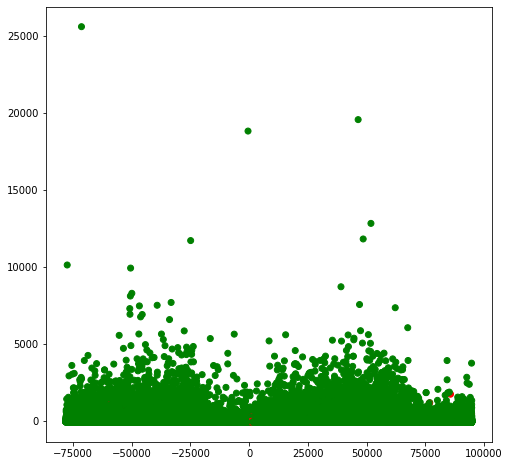

In [8]:
color = np.where(y == 1, 'red', 'green')
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)

There seems to be little to no information here. Let's try this with a sample

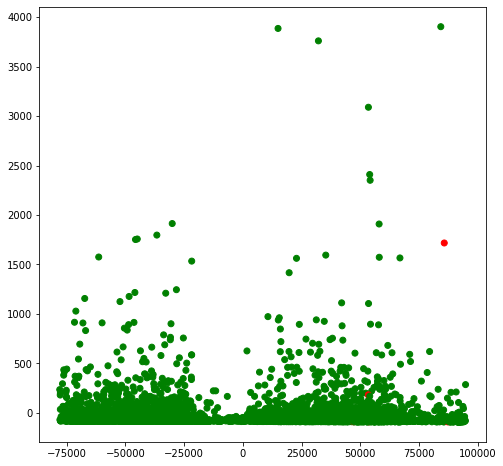

In [9]:
samples = np.random.choice(np.arange(X.shape[0]), np.sum(y == 1) * 10)
X_sample, y_sample = X_reduced[samples], y[samples]
color = np.where(y_sample == 1, 'red', 'green')
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=color)    

It seems that there is little information provided by the PCA in terms of seperability of the target variable (the fradulent clients are represented by a red dot in here). This pushes us to dive deeper into the data analysis.

In [10]:
# Check if the data is clean
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227846 entries, 0 to 227845
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227846 non-null  float64
 1   V1      227846 non-null  float64
 2   V2      227846 non-null  float64
 3   V3      227846 non-null  float64
 4   V4      227846 non-null  float64
 5   V5      227846 non-null  float64
 6   V6      227846 non-null  float64
 7   V7      227846 non-null  float64
 8   V8      227846 non-null  float64
 9   V9      227846 non-null  float64
 10  V10     227846 non-null  float64
 11  V11     227846 non-null  float64
 12  V12     227846 non-null  float64
 13  V13     227846 non-null  float64
 14  V14     227846 non-null  float64
 15  V15     227846 non-null  float64
 16  V16     227846 non-null  float64
 17  V17     227846 non-null  float64
 18  V18     227846 non-null  float64
 19  V19     227846 non-null  float64
 20  V20     227846 non-null  float64
 21  V21     22

Text(0.5, 1, 'Heatmap of Correlation')

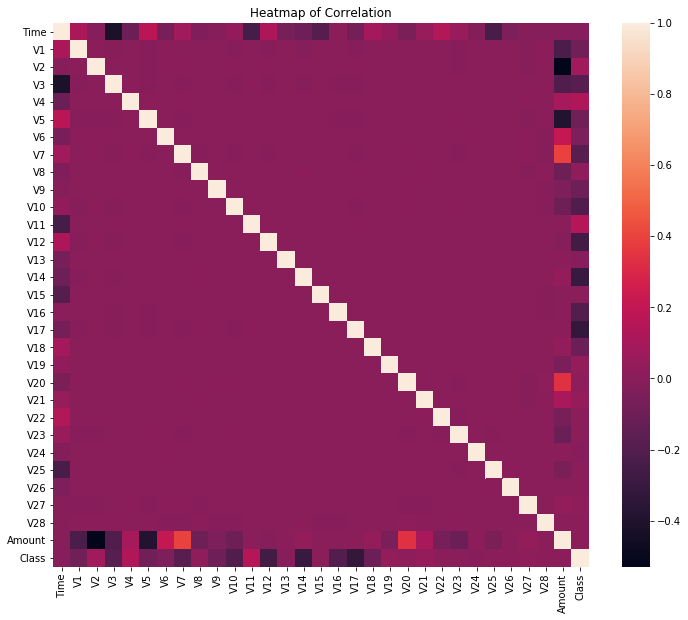

In [11]:
#heatmap
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

We can see that $(V_i)_{i \in \{1,\cdots,28\}}$ is a sequence of uncorrelated variable.

In [12]:
X, y = np.array(df.drop(columns=['Class'])), np.array(df.Class)

### An unbalanced problem

In [13]:
df_0 = df[df.Class == 0]
df_1 = df[df.Class == 1]

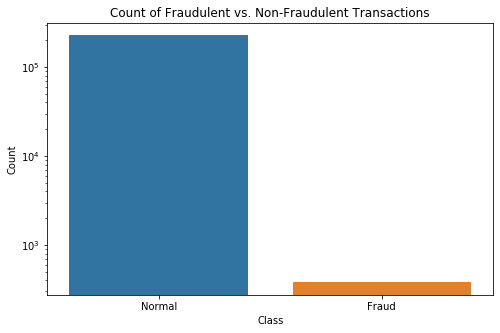

In [14]:
counts = df.Class.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(counts.index, counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.yscale('log')
plt.show()

In [15]:
print('There are {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(counts[0], counts[0] * 100 / df.shape[0], counts[1], counts[1] * 100 / df.shape[0]))

There are 227467 non-fraudulent transactions (99.834%) and 379 fraudulent transactions (0.166%).


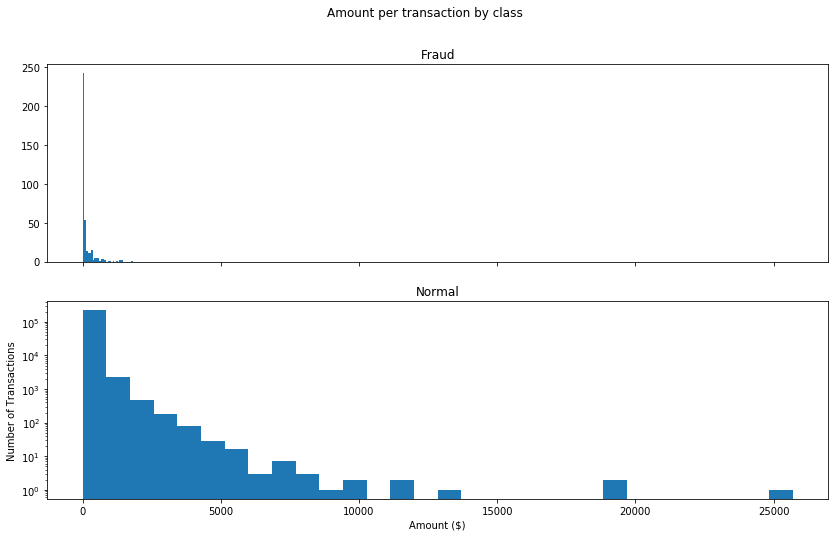

In [16]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(14,8))
f.suptitle('Amount per transaction by class')
bins = 30
axs[0].hist(df_1.Amount, bins = bins)
axs[0].set_title('Fraud')
axs[1].hist(df_0.Amount, bins = bins)
axs[1].set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

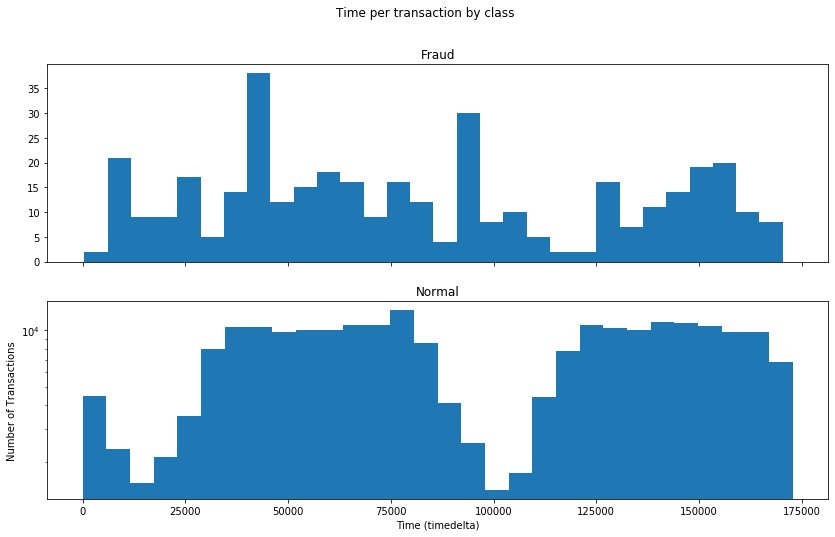

In [17]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(14,8))
f.suptitle('Time per transaction by class')
bins = 30
axs[0].hist(df_1.Time, bins = bins)
axs[0].set_title('Fraud')
axs[1].hist(df_0.Time, bins = bins)
axs[1].set_title('Normal')
plt.xlabel('Time (timedelta)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [20]:
print("For fraudulent clients:")
X_fraud = X[:, 0][np.where(y == 1)]
print("Mean: ", X_fraud.mean(), ", Standard Deviation: ", X_fraud.std())
print("Min: ", X_fraud.min(), " and max: ", X_fraud.max(), "\n")

print("For non fraudulent clients:")
X_normal = X[:, 0][np.where(y == 0)]
print("Mean: ", X_normal.mean(), ", Standard Deviation: ", X_normal.std())
print("Min: ", X_normal.min(), " and max: ", X_normal.max(), "\n")

For fraudulent clients:
Mean:  82024.79683377309 , Standard Deviation:  48228.90029074101
Min:  406.0  and max:  170348.0 

For non fraudulent clients:
Mean:  94824.98250735272 , Standard Deviation:  47501.835288279144
Min:  0.0  and max:  172792.0 



It appears that the mean of the variable **Time** for clients that have committed fraud is shifted when compared to the other clients, but this shift is not very clear as the standard deviation is too big to prevent an overlap. The fraudulent client's data seems also engulfed in the normal data (when we compare the max and min values). The histogram shows little to no correlation with the **Time** feature and the target variable. We will be omitting for the next steps.

In [21]:
X, y = np.array(df.drop(columns=['Class', 'Time'])), np.array(df.Class)

## Metric

In binary classification problem, the natural metric is the accuracy defined by : $\frac{1}{n}\sum_{i=1}^n\mathbb{1}\{y_i^{true}=y_i^{pred}\}$.

Let's look at the score using the optimistic predictor that only predicts normal transactions:

In [22]:
X_train , X_test, y_train, y_test = train_test_split(X, y)
y_pred = np.zeros(y_test.shape)
score = accuracy_score(y_test, y_pred)
print('The accuracy for the optimistic predictor is {:.3f}'.format(score))

The accuracy for the optimistic predictor is 0.999


The accuracy seems good, this shows the limit of this metric. Indeed, we are in an unbalanced classification problem, therfore predicting always the majoritary class leads to a good accuracy.
To see exactly what happens we use the confusions matrix

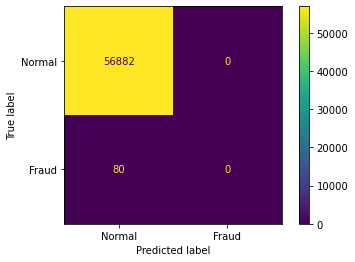

In [11]:
CM = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
CM.plot()
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.yticks(range(2), ['Normal', 'Fraud'])
plt.show()

We can see that 128 fraudulent cases are predicted as normal transactions. Our problematic is totaly not solved.

Other classification measures based on the confusion matrix are:

![](images/2.PNG)
Source: Wikipedia (en.wikipedia.org/wiki/sensitivity_and_specificity)

Standard classification measure such as TPR and TNR are misleading assessment measures in unbalanced class problem.
Imagine a classifier with TPR=99%
and TNR=99% , if we have 1% of positive samples, then Precision is only 0.5.
Even worse, if we have only 0.1% of positives, then Precision is 0.09.


In credit card fraud, precision and F-measure are considered the most
important indicators. Precision is the ratio of the number of
real positive cases and the number of predicted positive cases.
In the detection of credit card fraud, the first goal is to provide
the maximum truth, that is, the highest precision. In practice,
a false alarm can lead to a poor customer experience, and
potentially lead to the loss of customers, so the precision
of the model is very important, and is considered the most
important indicator of the fraud system. On the other hand,
although precision can be increased by reducing the model’s
recall rate, it is impossible to improve the precision by
reducing the recall rate without limitation. Recall rate is
the ratio of the number of predicted positive cases to the
number of all real positive cases. Real fraud problems have
real negative economic implications to the enterprise, so the
recall rate is also worthy of our attention. Another indicator
is the F-measure.
The F-measure captures both the precision and recall rate,
measuring improvements in both indicators simultaneously.




## Techniques for unbalanced classification tasks
Learning from unbalanced datasets is a difficult task since most learning algorithms are
not designed to cope with a large difference between the number of cases belonging to
different classes.

There are several methods that deal with this problem and we can
distinguish between methods that operate at the data and algorithmic levels.

 At
the data level, the unbalanced strategies are used as a pre-processing step to rebalance
the dataset or to remove the noise between the two classes, before any algorithm is
applied. At the algorithmic level, algorithms are themselves adjusted to deal with the
minority class detection.


### Oversampling

Oversampling consists in up-sizing the small class by:
* generating synthetic examples in the
neighborhood of observed ones (SMOTE)
* replicating the minority class until the two classes have equal frequency




In [12]:
svm_smote = SVMSMOTE(n_jobs=-1)
X_svm , y_svm = svm_smote.fit_resample(X, y)

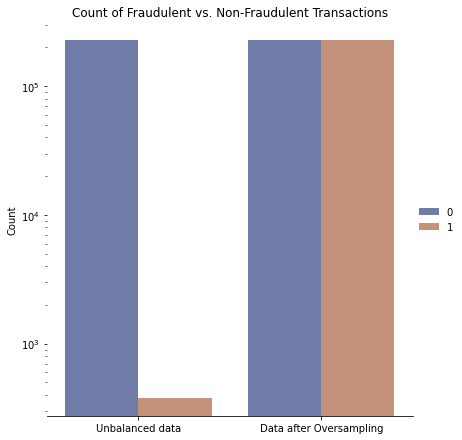

There are 227467 non-fraudulent transactions and 379 fraudulent transactions in the imbalanced data.
There are 227467 non-fraudulent transactions and 227467 fraudulent transactions after oversampling.


In [13]:
data = pd.concat((pd.value_counts(y), pd.value_counts(y_svm))).reset_index()
data.columns = ['Class', 'Counts']
data['Label'] = ['Unbalanced data', 'Unbalanced data', 'Data after Oversampling', 'Data after Oversampling']
g = sns.catplot(
    data=data, kind="bar",
    x="Label", y="Counts", hue="Class",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")
g.set(yscale='log')
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()
print('There are {} non-fraudulent transactions and {} fraudulent transactions in the imbalanced data.'.format(data['Counts'].iloc[0], data['Counts'].iloc[1]))
print('There are {} non-fraudulent transactions and {} fraudulent transactions after oversampling.'.format(data['Counts'].iloc[-2], data['Counts'].iloc[-1]))

### Undersampling

Undersampling consists in downsizing the majority class by:
*  randomly selecting a subset of data for the targeted class
*  removing observations from the majority class that are closed to the minority class region in order to return a dataset that presents a better separation between the two classes. (Tomek link)
*  eliminating the exemples from the majority class that are distant from the decision border



In [14]:
repENN = RepeatedEditedNearestNeighbours(n_neighbors=20, n_jobs=-1)
X_repENN, y_repENN = repENN.fit_resample(X, y)


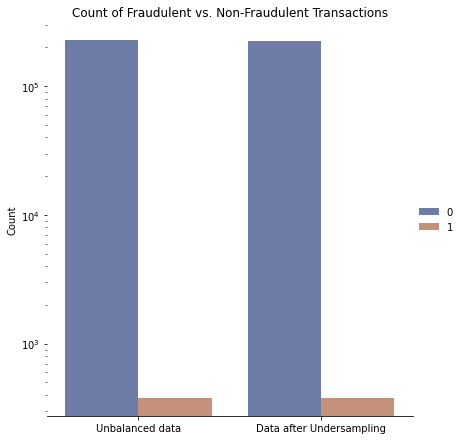

There are 227467 non-fraudulent transactions and 379 fraudulent transactions in the imbalanced data.
There are 226306 non-fraudulent transactions and 379 fraudulent transactions after undersampling.


In [15]:
data = pd.concat((pd.value_counts(y), pd.value_counts(y_repENN))).reset_index()
data.columns = ['Class', 'Counts']
data['Label'] = ['Unbalanced data', 'Unbalanced data', 'Data after Undersampling', 'Data after Undersampling']
g = sns.catplot(
    data=data, kind="bar",
    x="Label", y="Counts", hue="Class",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")
g.set(yscale='log')
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()
print('There are {} non-fraudulent transactions and {} fraudulent transactions in the imbalanced data.'.format(data['Counts'].iloc[0], data['Counts'].iloc[1]))
print('There are {} non-fraudulent transactions and {} fraudulent transactions after undersampling.'.format(data['Counts'].iloc[2], data['Counts'].iloc[3]))

### Combining over and under sampling

In [21]:
X_comb, y_comb = RepeatedEditedNearestNeighbours(sampling_strategy='all', n_neighbors=20, n_jobs=-1).fit_resample(X_svm, y_svm)

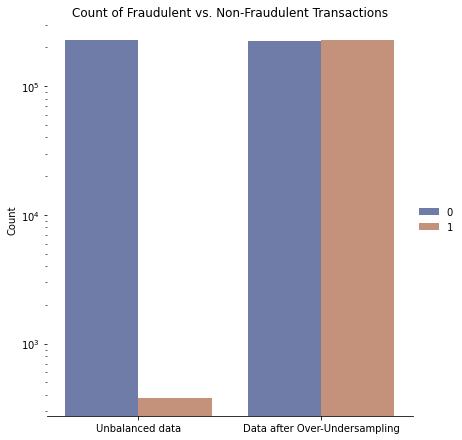

There are 227467 non-fraudulent transactions and 379 fraudulent transactions in the imbalanced data.
There are 227270 non-fraudulent transactions and 225945 fraudulent transactions after combining over and undersample.


In [22]:
data = pd.concat((pd.value_counts(y), pd.value_counts(y_comb))).reset_index()
data.columns = ['Class', 'Counts']
data['Label'] = ['Unbalanced data', 'Unbalanced data', 'Data after Over-Undersampling', 'Data after Over-Undersampling']
g = sns.catplot(
    data=data, kind="bar",
    x="Label", y="Counts", hue="Class",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")
g.set(yscale='log')
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()
print('There are {} non-fraudulent transactions and {} fraudulent transactions in the imbalanced data.'.format(data['Counts'].iloc[0], data['Counts'].iloc[1]))
print('There are {} non-fraudulent transactions and {} fraudulent transactions after combining over and undersample.'.format(data['Counts'].iloc[2], data['Counts'].iloc[3]))

### Logistic Regression

Let's start by using Logistic Regression on the unbalanced dataset, we use cross validation to select the best regularization parameter.

In [23]:
C = [10 ** i for i in range(-4, 5)]
print("Score using the unbalanced dataset...")
print(' | '.join([name.center(10) for name in ["C", "precision", "recall", "f-score"]]))
for c in C:
    model = LogisticRegression(C=c)
    cvscore = cross_validate(model, X, y, groups=y, scoring=['precision', 'recall', 'f1'], cv=10, n_jobs=-1)
    print(' | '.join([("%.4f" % c).rjust(10), ("%.3f" % np.mean(cvscore['test_precision'])).rjust(10), ("%.3f" % np.mean(cvscore['test_recall'])).rjust(10), ("%.3f" % np.mean(cvscore['test_f1'])).rjust(10)]))


Score using the unbalanced dataset...
    C      | precision  |   recall   |  f-score  
    0.0001 |      0.782 |      0.208 |      0.324
    0.0010 |      0.855 |      0.507 |      0.634
    0.0100 |      0.871 |      0.612 |      0.715
    0.1000 |      0.860 |      0.612 |      0.712
    1.0000 |      0.847 |      0.620 |      0.713
   10.0000 |      0.844 |      0.652 |      0.734
  100.0000 |      0.852 |      0.620 |      0.716
 1000.0000 |      0.822 |      0.633 |      0.714
10000.0000 |      0.844 |      0.638 |      0.725


The best paramater is $C=10000$ the precision score is good but we can improve the recall to increase f1 score. Let's try tu use undersampling method.

In [27]:
svm_smote = SVMSMOTE(n_jobs=-1)
renn = RepeatedEditedNearestNeighbours(n_neighbors=20, n_jobs=-1)
skf = StratifiedKFold(n_splits=10)
d = dict()
print("Score using  undersampling...")
print(' | '.join([name.center(10) for name in ["C", "precision", "recall", "f-score"]]))
for train, test in skf.split(X, y, groups=y):
    X_under, y_under = renn.fit_resample(X[train], y[train])
    for c in C:
        if str(c) not in d.keys():
            d[str(c)] = {'test_precision' : [], 'test_recall' : [], 'test_f1' : []}
        model = LogisticRegression(C=c)
        model.fit(X_under, y_under)
        y_pred = model.predict(X[test])
        y_true = y[test]
        d[str(c)]['test_precision'].append(precision_score(y_true, y_pred))
        d[str(c)]['test_recall'].append(recall_score(y_true, y_pred))
        d[str(c)]['test_f1'].append(f1_score(y_true, y_pred))
for c in C:
    print(' | '.join([("%.4f" % c).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_precision'])).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_recall'])).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_f1'])).rjust(10)]))



Score using  undersampling...
    C      | precision  |   recall   |  f-score  
    0.0001 |      0.816 |      0.261 |      0.389
    0.0010 |      0.850 |      0.612 |      0.710
    0.0100 |      0.809 |      0.805 |      0.805
    0.1000 |      0.771 |      0.813 |      0.790
    1.0000 |      0.764 |      0.813 |      0.786
   10.0000 |      0.765 |      0.818 |      0.789
  100.0000 |      0.761 |      0.818 |      0.787
 1000.0000 |      0.764 |      0.816 |      0.787
10000.0000 |      0.770 |      0.816 |      0.791


We see that under-sampling improve our model we keep $C=0.01$. 

Let's try to combine over and undersampling:

In [24]:
svm_smote = SVMSMOTE(n_jobs=-1)
renn = RepeatedEditedNearestNeighbours(n_neighbors=20, n_jobs=-1)
skf = StratifiedKFold(n_splits=10)
d = dict()
print("Score using over and undersampling...")
print(' | '.join([name.center(10) for name in ["C", "precision", "recall", "f-score"]]))
for train, test in skf.split(X, y, groups=y):
    X_over, y_over = svm_smote.fit_resample(X[train], y[train])
    X_comb, y_comb = renn.fit_resample(X_over, y_over)
    for c in C:
        if str(c) not in d.keys():
            d[str(c)] = {'test_precision' : [], 'test_recall' : [], 'test_f1' : []}
        model = LogisticRegression(C=c)
        model.fit(X_comb, y_comb)
        y_pred = model.predict(X[test])
        y_true = y[test]
        d[str(c)]['test_precision'].append(precision_score(y_true, y_pred))
        d[str(c)]['test_recall'].append(recall_score(y_true, y_pred))
        d[str(c)]['test_f1'].append(f1_score(y_true, y_pred))
for c in C:
    print(' | '.join([("%.4f" % c).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_precision'])).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_recall'])).rjust(10), ("%.3f" % np.mean(d[str(c)]['test_f1'])).rjust(10)]))



Score using over and undersampling...
    C      | precision  |   recall   |  f-score  
    0.0001 |      0.166 |      0.866 |      0.277
    0.0010 |      0.192 |      0.871 |      0.315
    0.0100 |      0.216 |      0.871 |      0.345
    0.1000 |      0.226 |      0.866 |      0.357
    1.0000 |      0.225 |      0.866 |      0.356
   10.0000 |      0.222 |      0.866 |      0.352
  100.0000 |      0.225 |      0.866 |      0.356
 1000.0000 |      0.225 |      0.866 |      0.357
10000.0000 |      0.221 |      0.866 |      0.352


The precision score is very bad.. The problem is that oversampling create to many fraudulent cases. Fortunately we can control the ratio of the number of samples in the minority class over the number of samples in the majority.

In [4]:
params = [0.1 * i for i in range(1,11)]
print("Score using : \n -oversampling with different ratios \n -undersampling \n -Logit Regression with C=0.01 \n \n")
print(' | '.join([name.center(10) for name in ["ratio P/N", "precision", "recall", "f-score"]]))
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
ratio = np.sum(y_train == 1) / np.sum(y_train == 0)
for r in params:
    param = (1 + r) * ratio
    svm_smote = SVMSMOTE(sampling_strategy=param, n_jobs=-1)
    renn = RepeatedEditedNearestNeighbours(n_neighbors=20, n_jobs=-1)
    logit = LogisticRegression(C=0.01)
    model = Pipeline([('smt', svm_smote), ('renn', renn), ('logit', logit)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    p = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    print(' | '.join([("%.5f" % param).rjust(10), ("%.3f" % p).rjust(10), ("%.3f" % re).rjust(10), ("%.3f" % f).rjust(10)]))

Score using : 
 -oversampling with different ratios 
 -undersampling 
 -Logit Regression with C=0.01 
 

ratio P/N  | precision  |   recall   |  f-score  
   0.00183 |      0.878 |      0.758 |      0.814
   0.00200 |      0.877 |      0.747 |      0.807
   0.00216 |      0.802 |      0.768 |      0.785
   0.00233 |      0.804 |      0.779 |      0.791
   0.00250 |      0.804 |      0.779 |      0.791
   0.00266 |      0.779 |      0.779 |      0.779
   0.00283 |      0.763 |      0.779 |      0.771
   0.00300 |      0.771 |      0.779 |      0.775
   0.00316 |      0.771 |      0.779 |      0.775
   0.00333 |      0.779 |      0.779 |      0.779


We don't use cross validation to evaluate the model, it take too much time but we can see that oversampling doesn't improve our model..


## References


[1] Andrea Dal Pozzolo. Adaptive machine learning for credit card fraud detection.
PhD Thesis, 2015 (http://di.ulb.ac.be/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf)
